In [1]:
import sys
! {sys.executable} -m pip install datasketch

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasketch import HyperLogLog, HyperLogLogPlusPlus
import itertools 

# HyperLogLog algorithm for cardinality estimation

## Summary

## Terms

* The term "**cardinality**" is used to mean the number of distinct elements in a data stream with repeated elements. Cardinality estimation is the task of determining the number of distinct elements in a data stream y estimation
* The term "**dataset**" is used as synonim for "**multiset**" 

## Problem: Cardinality estimation on huge multiset

### Calculating distinct count
    Calculating a distinc count in a given multiset has a trivial implemention. There are structures in modern languages that makes implmentation easy.

```typescript
// psudo code
const map = new Map();

for(record in ordersDataset) {
    map.add(record.customerName)
}

consoloe.log("The distinc count of customers in the multiset is" + map.size)

```
The Map implementation may varry form $ \mathcal{O}(log(n)) $ to $ \mathcal{O}(n) $.
    This means the complexyty along with the multiset elements itearation will be $ \mathcal{O}(n^2)  $. **Not so bad !**. Not at all, but we are calculating only the computational complexity.

### What about memory footprint ?

    In order to calculate all distinc values,we need to keep all of them in memory. Despide the fact the Map/Hashtable structures are blazing fast, they have to keep either the hashed value or both hashed and real value in memory. This depends on the implmentation of the hastable and also of the value hashing function implementation. 
   Let us have a try. Let us assume that:
   * We are using MD5 has function which results in $128 bits = 16 Bytes$
* our values will be strings with average length of 50 chatarcters,  charset UTF-8. This means a single character is using $32 Bits = 4 Bytes$
* our hastabe stores the has and the real values, so that it handles hash collisions well

Based on the given data we can calculate the following formula for estimating memory footprint:

$$ size(text) = len(text)*4 Bytes $$

$$ AllocatedMemeory = \sum_{i=1}^{n} (size(text_n) + 16)$$

This means that calculating the exact cardinality of the distinct elements in a dataset requires an amount of memory proportional to the cardinality, which is impractical for very large data sets

Single string memory footpring will be $ 50 * 5 + 16 = 266 Bytes$. Sample memory foorpints based on distinct count memebers:

| Dataset cardinality | Memory size (Byte) | Fromated memory size |
|---------------------|--------------------|----------------------|
| 100000              | 26600000           | 26,60 MB             |
| 1000000             | 266000000          | 266,00 MB            |
| 1000000000          | 266000000000       | 266,00 GB            |
So we need at least 256 GB Memory the supportive Hashtable(Map) structure alone in order to calculateting the distinct count of a co valueslumn in a single dataset wtih cardinality 1 000 000 000
### Can we reuse the already calculated cardianlity and cache it ?
Yes we can - we can keep and memoize that for a given dataset and column customers we have $5*10^5$ distinct memebers. This has its advantages,  but it has one significant disatvantage: we cannot combine the cardinality of two separate cached datasets. So if **A** and **B** are two multisets:
 $$ A \neq B $$
 $$ cardinality(A) + cardinality(B) \neq carinality(A \cup B)  $$
$$ max(cardinality(A), cardinality(B)) \le carinality(A \cup B) \le cardinality(A) + cardinality(B) $$

## Count-distinct estimaion
Cardinality estimation is a prediction of the distinct count values over a dataset column orIt is used where we want to sacriface 100% correctness of the results in order to get performance in terms of memory or cache optimization.

Examples:
* What is the estimated distinc count of customers over an or
* What is the etimated distinc count of words in a given tex
* Biological dat analisysa*  dataset.
* Cardinality etimation is used by SQL engines Query planners (not only) to predict how many distinct elements exists in given dataset. This information is used to generate optimal queryg
.




## Hyper Log Log Algorithm

### Hyper Log Log definittion
> The basis of the HyperLogLog algorithm is the observation that the cardinality of a multiset of uniformly distributed random numbers can be estimated by calculating the maximum number of leading zeros in the binary representation of each number in the multiset. If the maximum number of leading zeros observed is n, an estimate for the number of distinct elements in the multiset is $2^n$
>
> In the HyperLogLog algorithm, a hash function is applied to each element in the original multiset to obtain a multiset of uniformly distributed random numbers with the same cardinality as the original multiset. The cardinality of this randomly distributed set can then be estimated using the algorithm above.
>
> The simple estimate of cardinality obtained using the algorithm above has the disadvantage of a large variance. In the HyperLogLog algorithm, the variance is minimised by splitting the multiset into numerous subsets, calculating the maximum number of leading zeros in the numbers in each of these subsets, and using a harmonic mean to combine these estimates for each subset into an estimate of the cardinality of the whole set.
> 
> -- <cite>[wikipedia][HLL_wikipedia]</cite>


### Memory footprint

The new HLL algorithm makes it possible to estimate cardinalities well beyond $10^9$ with a typical error rate of 2% while using a memory of only 1.5 kilobytes.




[HLL_wikipedia]: https://en.wikipedia.org/wiki/HyperLogLog

### Hyper log log operations
The HyperLogLog has three main operations:
1. **add** -> adds a new element to the set
2. **count** -> obtains the cardinality of the set
3. **merge** -> obtains the union of two sets

We can define some more (derived operations) which combines the merge of two sets and count on them:
* **cardinality of the intersection**
* **cardinality of the difference**

#### HLL add operation
The add operation consists of computing the hash of the input data $v$ with a hash function $h$, getting the first $b$ bits (where $b$ is $log_2(m)$ ), and  and adding 1 to them to obtain the address of the register to modify. With the remaining bits compute $\rho(\omega)$ which returns the position of the leftmost 1, where leftmost position is 1 (in other words: number of leading zeros plus 1). The new value of the register will be the maximum between the current value of the register and $\rho(\omega)$

$$x := h(v)$$
$$j:= 1 + \langle{x_1x_2...x_b}\rangle_2$$
$$\omega := x_{b+1}x_{b+2}...$$
$$M[j]:=max(M[j],\rho(\omega))$$

#### HLL Count operation

The count algorithm operation consists in computing the harmonic mean of the $m$ registers, and using a constant to derive an estimate $E$ of the count:
$$Z = 	\bigg( {\sum_{j=1}^m{2^{-M[j]}}} \bigg)^{-1} $$
$$\alpha_m = \bigg( m\int_0^\infty \bigg( log_2{\bigg( \cfrac{2 + u}{1 + u} \bigg)}\bigg)^m du  \bigg)^{-1} $$
$$E = \alpha_mM^2Z$$

The intuition is that $n$ being the unknown cardinality of $M$, each subset $M_j$ will have $n/m$ elements. Then for $max_{x \in M_j}(\rho(x))$ should be close to $log_2(m/n)$. The harmonic mean of 2 to theese quanitites is $mZ$ which should be near $m/n$. Thus, $m^2Z \simeq n$. Finally the nostant $\alpha_m$ is introduced to correct a systematic multicaptive bias present in $m^2Z$ due to hash collisions

According to the [HLL the analysis of a near-optimal cardinality estimation algorithm][HLL the analysis of a near-optimal cardinality estimation algorithm]
The constant $\alpha_m$ is not simple to calculate and can be approximated with the formula:
$$  a_m \approx \begin{cases} 0.673, & \text{for } m = 16; \\ 0.697, & \text{for } m = 32; \\ 0.709, & \text{for } m = 64; \\ \frac{0.7213}{1+1.079/m}, & \text{for } m \geq 128. \end{cases}$$



[HLL the analysis of a near-optimal cardinality estimation algorithm]: https://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf "HyperLogLog: the analysis of a near-optimal 
cardinality estimation algorithm"


#### HLL merge operation

The merge operation for two HLLs ($hll_1, hll_2$) is obtaining the maximum for each pair of registers $j:1..m$
$$ hll_union[j] = max(hll1[j], hll2[j]) $$

Now the restriction of linear counting and combining two cardinalities can be achieved. Lets introduce operation merge of two cardinalities with the sign of $\oplus$. 
$$ M_1, M_2, M_3 \text{ are multisets} $$
$$ M_1 \neq M_2 \neq M_3 $$
$$ hll = f(x), \text{where } x \text{ is a multiset} $$
$$ m_1 = hll(M_1) $$
$$ m_2 = hll(M_2) $$
$$ m_3 = hll(M_3) $$
$$ m_1 \oplus m_2 = hll(M_1 \cup M_2) $$
$$ m_1 \oplus m_2 = m_2 \oplus m_1 $$
$$ (m_1 \oplus m_2 ) \oplus m_3 = m_1 \oplus ( m_2 \oplus m_3 ) $$

### Error rates based on p
We will use a public datasource to observe how error rate changes based on chane of $p$, where $m = 2 ^p$. The theory tells us we have tipycal error rate of 2%


C:\Users\igenchev\anaconda3\Lib\site-packages\datasketch\hyperloglog.py:151: UserWarning: Warning: estimate is close to error correction threshold. Output may not satisfy HyperLogLog accuracy guarantee.
  warnings.warn(


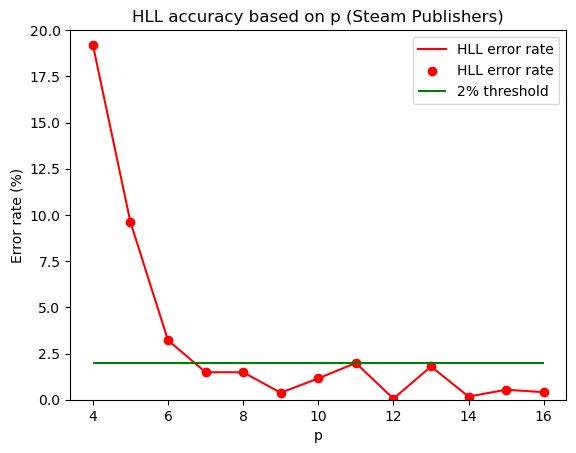

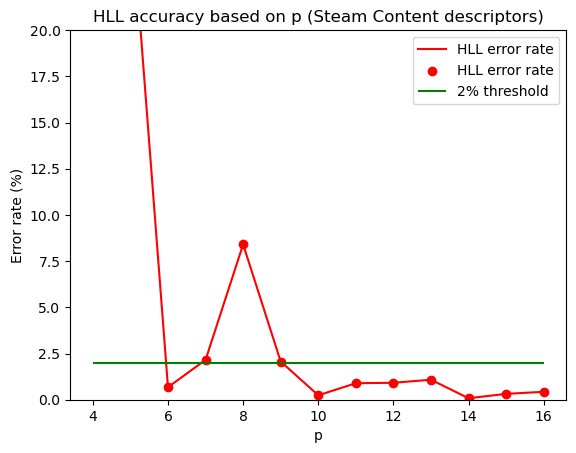

In [183]:
steam_games = pd.read_csv('data/steam-games.csv')
steam_publishers = steam_games['publisher'].to_numpy(na_value='no value')
steam_titles = steam_games['title'].to_numpy(na_value='no value')
steam_developers = steam_games['developer'].to_numpy(na_value='no value')
steam_content_descriptors = steam_games['content_descriptor'].to_numpy(na_value='no value')

def get_error_rate(estiamtedCount, realCount):
    return np.abs(estiamtedCount - realCount) * 100 / realCount

def get_hll_obj(dataset, p = 10):
    _hll = HyperLogLog(p)
    for value in dataset:
        if isinstance(value, str):
            _hll.update(value.encode("utf-8"))
    return _hll

def plot_error_rates(title, x_label, y_label, x_values, y_values, before_draw = None, prepend_legend = None ):
    x_min = np.min(x_values)
    x_max = np.max(x_values)
    plt.title(title)

    if (before_draw != None):
        before_draw(plt)

    legend_labels = ["HLL error rate", "HLL error rate" , "2% threshold"]
    if ( prepend_legend != None ):
        legend_labels = prepend_legend + legend_labels 

    plt.plot(x_values, y_values, c = "red")
    plt.scatter(x_values, y_values, c = "red")
    plt.hlines(2.0, xmin=x_min , xmax = x_max, colors="green") 
    plt.legend(legend_labels)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim([0, 20])
    plt.show()
    pass

def print_error_based_on_precision(input, dataset_name):
    real_distinct_count = len(set(input))
    pValues = range(4, 17)
    hlls = [get_hll_obj(input, p) for p in pValues]
    error_rates_in_percent = [ get_error_rate(hll.count(), real_distinct_count)  for hll in hlls]
    plot_error_rates(f"HLL accuracy based on p ({dataset_name})", "p",  "Error rate (%)", pValues, error_rates_in_percent)
    pass


print_error_based_on_precision(steam_publishers, "Steam Publishers")
print_error_based_on_precision(steam_content_descriptors, "Steam Content descriptors")

### Error rates based on real cardinality
We will oberve the error rates based on the input cardinality

C:\Users\igenchev\anaconda3\Lib\site-packages\datasketch\hyperloglog.py:151: UserWarning: Warning: estimate is close to error correction threshold. Output may not satisfy HyperLogLog accuracy guarantee.
  warnings.warn(


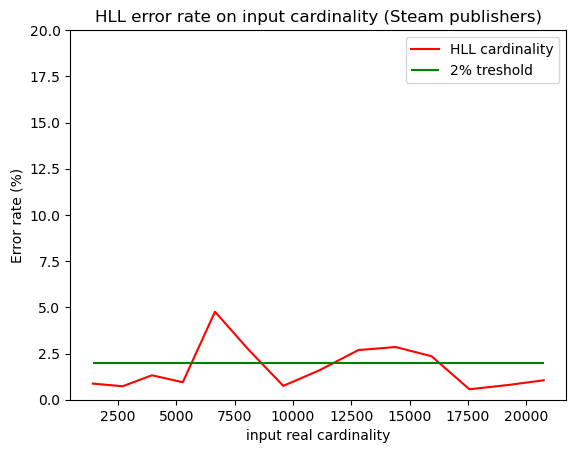

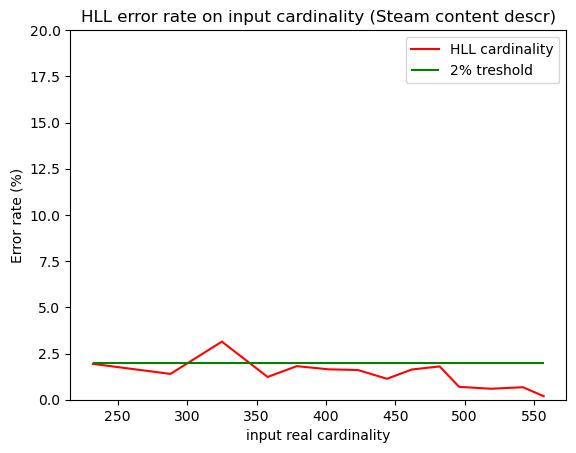

In [173]:
def get_hll_obj(dataset, p = 10):
    _hll = HyperLogLog(p)
    for value in dataset:
        if isinstance(value, str):
            _hll.update(value.encode('utf-8'))
    return _hll

def plot_error_input_cardinality(input, dataset_name, input_step = 3000):
    input_count = range(input_step, len(input), input_step)
    datasets = [ input[:count] for count in input_count ]
    
    datasets_cardinality = [ len(set(dataset)) for dataset in datasets]
    hyperLogLogs = [ get_hll_obj(dataset) for dataset in datasets ]
    estimated_cardinality = [ hll.count() for hll in hyperLogLogs ]
    error_rates = [ get_error_rate(estimmated, real) for (real, estimmated) in zip(datasets_cardinality, estimated_cardinality) ]

    plot_error_rates(f"HLL error rate on input cardinality ({dataset_name})", "input real cardinality",  "Error rate (%)", datasets_cardinality, error_rates)

plot_error_input_cardinality(steam_publishers, "Steam publishers")
plot_error_input_cardinality(steam_content_descriptors, "Steam content descr")

### Lets try the merge of two hyperlog logs and what error rate it has
We will try to merge to hll registries and we should recieve as if we have done this separately

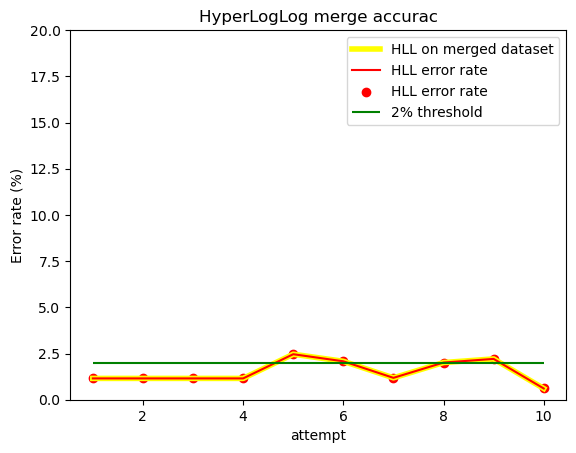

In [187]:
def get_merged_cardinality(hll1, hll2):
    # We intentionally create new HLL object, not to modify the original ones
    newHLL = HyperLogLog( p = 10, reg=hll1.reg)
    newHLL.merge(hll2)
    return newHLL.count()


def print_merged_cardinality_error(input, chunks_count = 5):
    chunked_datasets = [ input[::step] for step in range(1, chunks_count +1)] 

    hll_for_merge =  [ get_hll_obj(dataset) for dataset in chunked_datasets ]
    
    dataset_indexes_to_merge = list(itertools.combinations(range(chunks_count), 2))
    
    merged_datasets = [ np.concatenate((chunked_datasets[indexes[0]],chunked_datasets[indexes[1]])) for indexes in dataset_indexes_to_merge ]
    merged_real_cardinality = [ len(set(dataset))  for dataset in merged_datasets ]
    merged_estimatd_cardinality = [ get_merged_cardinality(hll_for_merge[indexes[0]], hll_for_merge[indexes[1]]) for indexes in dataset_indexes_to_merge ]
    cardinality_of_merged_datasets = [get_hll_obj(dataset).count() for dataset in merged_datasets]
    merged_error_rate = [ get_error_rate(estimmated, real) for (real, estimmated) in zip(merged_real_cardinality, merged_estimatd_cardinality) ]
    error_rate_on_merged = [ get_error_rate(estimmated, real) for (real, estimmated) in zip(merged_real_cardinality, cardinality_of_merged_datasets)  ]
    merged_x = range(1 ,len(dataset_indexes_to_merge) + 1) 
    before_draw = lambda plt: plt.plot(merged_x, error_rate_on_merged, c = "yellow", linewidth = 4)
    plot_error_rates("HyperLogLog merge accuracy", "attempt",  "Error rate (%)", merged_x, merged_error_rate, before_draw=before_draw, prepend_legend=["HLL on merged dataset"])

print_merged_cardinality_error(steam_publishers)